# This follows from the workbook "New_binary_classification.ipynb"
## Based on the second half of Chapter 3 in O'Reilly book "Hands on Machine Learning 2"
## This notebook is based on the notebook accompanying this chapter  
The notebook is stored here on GCP, the relative path to this one is ../../handson-ml2/handson-ml2/03_classification.ipynb
#### We read in the Fasttext embedding already created and apply binary classification following the chapter
#### The notebook Non_binary_classification.ipynb follows on with non-binary classification

# Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os

# sklearn imports
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score


from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score


# imbalanced dataset metrics
from imblearn.metrics import classification_report_imbalanced

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Import vectorized CPA data
The vectorized columns are as follows:    
- Descr_cleaned_vectorized : FastText vectorization of the "Descr_cleaned" column
- Full_descr_cleaned_vectorized : FastText vectorization of the "Full_descr_cleaned" column
- Descr_Low_dim : Reduced dimension (UMAP 10 dimensions) of FastText vectorization of the "Descr_cleaned" column
- Full_descr_Low_dim : Reduced dimension (UMAP 10 dimensions) of FastText vectorization of the "Full_descr_cleaned" column

The first two columns listed above hold the full vectorization (about 300 dim- check) and the "Low_dim" ones are reduced dimenstion

In [2]:
# we need to ensure the columns of lists are imported as such
import ast
generic = lambda x: ast.literal_eval(x)
conv = {
        'Descr_Low_dim': generic,
        'Full_descr_Low_dim': generic}
CPA = pd.read_csv('../data/output/CPA_Vectorized.csv', converters=conv)

CPA = CPA[CPA.Level==6]
CPA = CPA.astype({'Category_0':int,'Category_2':int})
CPA.head()


,Code,Level,Descr_old,Descr,Includes,Category_0,Category_1,Category_2,Full_descr,Descr_cleaned,Full_descr_cleaned,Descr_cleaned_vectorized,Full_descr_cleaned_vectorized,Descr_Low_dim,Full_descr_Low_dim
5,01.11.11,6,Durum wheat,Durum wheat,NaN,1,A,1,Durum wheat,durum wheat,durum wheat,[-0.07021299 0.07487412 -0.08852207 -0.093424...,[-0.07021299 0.07487412 -0.08852207 -0.093424...,"[10.613475799560547, 1.6112016439437866, 6.889...","[10.080077171325684, 3.1135828495025635, 5.750..."
6,01.11.12,6,"Wheat, except durum wheat",Wheat,NaN,1,A,1,"Wheat, except durum wheat",wheat,wheat except durum wheat,[ 6.82471097e-02 5.72879892e-03 -2.74024643e-...,[-8.17044750e-02 4.43322510e-02 -1.21796057e-...,"[10.610937118530273, 1.6146502494812012, 6.886...","[10.07783031463623, 3.1349775791168213, 5.7314..."
8,01.11.20,6,Maize,Maize,NaN,1,A,1,Maize,maize,maize,[-2.75462180e-01 2.88966715e-01 -1.60463899e-...,[-2.75462180e-01 2.88966715e-01 -1.60463899e-...,"[10.598653793334961, 1.5319408178329468, 6.899...","[10.088605880737305, 3.1780178546905518, 5.732..."
10,01.11.31,6,Barley,Barley,NaN,1,A,1,Barley,barley,barley,[-0.48283365 -0.02554321 -0.09297911 0.358175...,[-0.48283365 -0.02554321 -0.09297911 0.358175...,"[10.606842994689941, 1.6108537912368774, 6.884...","[10.082571983337402, 3.0978615283966064, 5.779..."
11,01.11.32,6,Rye,Rye,NaN,1,A,1,Rye,rye,rye,[-0.23049644 0.07332443 -0.51851004 0.030723...,[-0.23049644 0.07332443 -0.51851004 0.030723...,"[10.645343780517578, 1.672475814819336, 6.8885...","[10.067237854003906, 3.0663797855377197, 5.772..."


## Split the CPA data into a training and a test set

In [51]:
# Split the CPA dataframe into train and test
train_set, test_set = train_test_split(CPA, test_size=0.2, random_state=42)
# The vector column will be the data we use for classification
col = 'Descr_Low_dim'
X_train = np.array(list(train_set[col]))
X_test = np.array(list(test_set[col]))

# we will use different levels of categorisation
# we can choose the level of categorisation here, Category_0, _1 or _2, and also the vectorisation to use
Cat = 'Category_0'
y_train_cat0 = np.array(list(train_set[Cat]))
y_test_cat0 = np.array(list(test_set[Cat]))
Cat = 'Category_1'
y_train_cat1 = np.array(list(train_set[Cat]))
y_test_cat1 = np.array(list(test_set[Cat]))
Cat = 'Category_2'
y_train_cat2 = np.array(list(train_set[Cat]))
y_test_cat2 = np.array(list(test_set[Cat]))

print(X_train.shape, y_train_cat1.shape)
X_train[:2]

(2574, 10) (2574,)


array([[10.24176407,  1.495134  ,  6.934062  ,  5.49697828,  5.47507858,
         6.19090939,  9.82301331,  7.17451763,  6.48560524,  4.21679831],
       [ 6.43087292,  2.48803687,  1.78880703,  3.02287507,  6.34812403,
         3.15756965,  0.56744212,  3.84727097,  6.04655981,  1.59090734]])

In [52]:
## To follow the book, let's set up a test item with categories we know
test_item = CPA[(CPA.Category_2==10)&(CPA.Category_1=='C')&(CPA.Category_0==2)].Descr_Low_dim[438]
test_item

[10.392472267150879,
 2.1317131519317627,
 7.459656238555908,
 6.61699104309082,
 4.1032819747924805,
 6.102914333343506,
 9.116209030151367,
 9.040961265563965,
 6.673974990844727,
 3.864978790283203]

# Imbalanced Data Metrics
Our data is imbalanced in the sense that the numbers of items in each class varies a lot.   
This section diagresses from the book.

NOTE: I had quite a lot of difficulty getting VS Code to recognise imblearn. Finally it worked using !pip install imblearn in jupyter cell directly

# Multiclass classification
Whereas binary classifiers distinguish between two classes, multiclass classifiers (also called multinomial classifiers) can distinguish between more than two classes.

Some algorithms (such as Logistic Regression classifiers, Random Forest classifiers, and naive Bayes classifiers) are capable of handling multiple classes natively. Others (such as SGD Classifiers or Support Vector Machine classifiers) are strictly binary classifiers. However, there are various strategies that you can use to perform multiclass classification with multiple binary classifiers.

** One-versus-rest **   
One way to create a system that can classify the digit images into 10 classes (from 0 to 9) is to train 10 binary classifiers, one for each digit (a 0-detector, a 1-detector, a 2-detector, and so on). Then when you want to classify an image, you get the decision score from each classifier for that image and you select the class whose classifier outputs the highest score. This is called the one-versus-the-rest (OvR) strategy (also called one-versus-all).

** One-versus-one **   
Another strategy is to train a binary classifier for every pair of digits: one to distinguish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on. This is called the one-versus-one (OvO) strategy. If there are N classes, you need to train N × (N – 1) / 2 classifiers. For the MNIST problem, this means training 45 binary classifiers! When you want to classify an image, you have to run the image through all 45 classifiers and see which class wins the most duels. The main advantage of OvO is that each classifier only needs to be trained on the part of the training set for the two classes that it must distinguish.

Some algorithms (such as Support Vector Machine classifiers) *scale poorly with the size of the training set*. For these algorithms OvO is preferred because it is faster to train many classifiers on small training sets than to train few classifiers on large training sets. ** For most binary classification algorithms, however, OvR is preferred. **


## Support Vector Machine classifier
Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass classification task, and it automatically runs OvR or OvO, depending on the algorithm. Let’s try this with a Support Vector Machine classifier (see Chapter 5), using the sklearn.svm.SVC class:

Under the hood, Scikit-Learn actually used the OvO strategy: it trained N * (N-1) binary classifiers, got their decision scores for the image, and selected the class that won the most duels.

If you call the decision_function() method, you will see that it returns N scores per instance (instead of just 1). That’s one score per class (it’s the number of won duels plus or minus a small tweak to break ties, based on the binary classifier scores)

In [6]:

svm_clf0 = SVC(gamma="auto", random_state=42)
svm_clf1 = SVC(gamma="auto", random_state=42)
svm_clf2 = SVC(gamma="auto", random_state=42)
svm_clf0.fit(X_train, y_train_cat0)
print('Scores for Category_0 : target is 2nd \n',svm_clf0.decision_function([test_item]))
svm_clf1.fit(X_train, y_train_cat1)
print('Scores for Category_1 : target is 3rd \n',svm_clf1.decision_function([test_item]))
svm_clf2.fit(X_train, y_train_cat2)
print('Scores for Category_1 : target is 3rd \n',svm_clf2.decision_function([test_item]))

Scores for Category_0 : target is 2nd 
 [[ 8.29784893  9.30140582  2.73598047  7.27305884  1.72272008  0.71475454
  -0.29611218  6.20043305  3.81638767  4.99894874]]
Scores for Category_1 : target is 3rd 
 [[19.31761568  9.94805749 20.31813263  6.71574784 12.18839512 10.92955875
  18.31215185 16.28514249  4.71007455  8.73576367  3.70409808  1.68890782
  15.28555923 17.29297943  2.69948015  5.74240527 13.22725539  7.7599955
  14.28103271  0.69076363 -0.31505816]]
Scores for Category_1 : target is 3rd 
 [[86.32977312 73.32235829 85.32908422  7.67329075 49.26075995 21.67703709
  24.67983317 33.68305329 87.32989489 77.32027593 75.3156973  80.32626072
  27.68346952 84.32805105 56.30773453 72.32399326 36.69054155 73.32402056
  80.32882196 49.22943733 54.28419396 62.31280486 52.28066299 66.32220154
  61.31582348 62.31865833 83.32922604 54.26984546 67.32302221 28.67887789
  80.32849547 76.32646244 49.19184403  3.67388919  4.67423176 70.32283417
   5.67444593 43.98628358 54.26737476 37.69147784

In [7]:
print('Accuracy for Category_0: ',cross_val_score(svm_clf0, X_train, y_train_cat0, cv=3, scoring="accuracy"))
print('\nAccuracy for Category_1: ',cross_val_score(svm_clf1, X_train, y_train_cat1, cv=3, scoring="accuracy"))
print('\nAccuracy for Category_2: ',cross_val_score(svm_clf2, X_train, y_train_cat2, cv=3, scoring="accuracy"))

Accuracy for Category_0:  [0.85314685 0.84615385 0.85547786]


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)



Accuracy for Category_1:  [0.82400932 0.82517483 0.81701632]


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)



Accuracy for Category_2:  [0.57342657 0.53030303 0.55011655]


In [8]:
y_train_pred_tmp = cross_val_predict(svm_clf1, X_train, y_train_cat1, cv=3)
conf_mx_tmp = confusion_matrix(y_train_cat1, y_train_pred_tmp)
conf_mx_tmp

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


array([[  78,    0,   78,    0,    0,    0,    0,    0,    0,    1,    0,
           0,    0,    0,    0,    0,    0,    0,    2,    0,    0],
       [   0,    0,   29,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [  30,    1, 1330,    0,    0,    1,   15,   14,    0,   14,    0,
           0,    2,    3,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    7,    3,    0,    0,    1,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,   11,    0,   47,    0,    0,    0,    0,    0,    0,
           0,    1,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,   19,    0,    0,   43,    1,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    2,    1,    0,    0,    0],
       [   0,    0,   19,    0,    0,    0,  162,    0,    0,    5,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0],

In [9]:
print(classification_report_imbalanced(y_train_cat1, y_train_pred_tmp))

                   pre       rec       spe        f1       geo       iba       sup

          A       0.72      0.49      0.99      0.58      0.70      0.46       159
          B       0.00      0.00      1.00      0.00      0.00      0.00        29
          C       0.87      0.94      0.83      0.91      0.89      0.79      1410
          D       1.00      0.27      1.00      0.43      0.52      0.25        11
          E       0.96      0.80      1.00      0.87      0.89      0.78        59
          F       0.93      0.65      1.00      0.77      0.81      0.63        66
          G       0.83      0.87      0.99      0.85      0.93      0.85       186
          H       0.82      0.79      0.99      0.80      0.88      0.76        98
          I       0.79      0.61      1.00      0.69      0.78      0.59        18
          J       0.67      0.87      0.98      0.76      0.93      0.85       110
          K       0.87      0.85      1.00      0.86      0.92      0.83        71
   

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Repeat this for the Category_0 and Category_2 classifications

In [10]:
y_train_pred_0 = cross_val_predict(svm_clf0, X_train, y_train_cat0, cv=3)
print(classification_report_imbalanced(y_train_cat0, y_train_pred_0))
y_train_pred_2 = cross_val_predict(svm_clf2, X_train, y_train_cat2, cv=3)
print(classification_report_imbalanced(y_train_cat2, y_train_pred_2))

                   pre       rec       spe        f1       geo       iba       sup

          1       0.72      0.49      0.99      0.58      0.70      0.46       159
          2       0.91      0.95      0.86      0.93      0.90      0.82      1509
          3       0.96      0.67      1.00      0.79      0.82      0.64        66
          4       0.78      0.88      0.97      0.83      0.92      0.84       302
          5       0.68      0.85      0.98      0.75      0.91      0.82       110
          6       0.88      0.85      1.00      0.86      0.92      0.83        71
          7       0.94      1.00      1.00      0.97      1.00      1.00        15
          8       0.72      0.65      0.98      0.68      0.80      0.61       184
          9       0.79      0.74      0.99      0.77      0.86      0.72        86
         10       0.67      0.36      0.99      0.47      0.60      0.34        72

avg / total       0.85      0.85      0.91      0.85      0.87      0.77      2574



/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


                   pre       rec       spe        f1       geo       iba       sup

          1       0.63      0.65      0.98      0.64      0.80      0.62       132
          2       0.00      0.00      1.00      0.00      0.00      0.00         7
          3       0.00      0.00      1.00      0.00      0.00      0.00        20
          5       0.00      0.00      1.00      0.00      0.00      0.00         1
          6       0.00      0.00      1.00      0.00      0.00      0.00         3
          7       0.00      0.00      1.00      0.00      0.00      0.00         7
          8       0.00      0.00      1.00      0.00      0.00      0.00        15
          9       0.00      0.00      1.00      0.00      0.00      0.00         3
         10       0.55      0.73      0.96      0.63      0.84      0.69       156
         11       0.67      0.46      1.00      0.55      0.68      0.44        13
         12       0.00      0.00      1.00      0.00      0.00      0.00         4
   

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Stochastic Gradient Descent Multi classifier
Training an SGDClassifier is just as easy

In [12]:
sgd_clf0 = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf1 = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf2 = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)

sgd_clf0.fit(X_train, y_train_cat0)
sgd_clf1.fit(X_train, y_train_cat1)
sgd_clf2.fit(X_train, y_train_cat2)

print('Accuracy for Category_0: ',cross_val_score(sgd_clf0, X_train, y_train_cat0, cv=3, scoring="accuracy"))
print('\nAccuracy for Category_1: ',cross_val_score(sgd_clf1, X_train, y_train_cat1, cv=3, scoring="accuracy"))
print('\nAccuracy for Category_2: ',cross_val_score(sgd_clf2, X_train, y_train_cat2, cv=3, scoring="accuracy"))

Accuracy for Category_0:  [0.68181818 0.79137529 0.72494172]


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)



Accuracy for Category_1:  [0.75291375 0.71794872 0.74825175]


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)



Accuracy for Category_2:  [0.28088578 0.16433566 0.21095571]


## Improving results using a scaler
These results are already a lot better than a random classifier.   
QUESTION: since our data is already vectorized, is using this scalar meaningful?

In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

print('Accuracy for Category_0: ',cross_val_score(sgd_clf0, X_train_scaled, y_train_cat0, cv=3, scoring="accuracy"))
print('\nAccuracy for Category_1: ',cross_val_score(sgd_clf1, X_train_scaled, y_train_cat1, cv=3, scoring="accuracy"))
print('\nAccuracy for Category_2: ',cross_val_score(sgd_clf2, X_train_scaled, y_train_cat2, cv=3, scoring="accuracy"))

Accuracy for Category_0:  [0.7972028  0.78088578 0.76223776]


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)



Accuracy for Category_1:  [0.75058275 0.75641026 0.75291375]


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)



Accuracy for Category_2:  [0.35431235 0.41608392 0.38111888]


In [15]:
y_train_pred_1 = cross_val_predict(sgd_clf1, X_train_scaled, y_train_cat1, cv=3)
conf_mx = confusion_matrix(y_train_cat1, y_train_pred_1)
conf_mx

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


array([[  67,    0,   88,    0,    0,    0,    0,    0,    0,    1,    0,
           0,    0,    3,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,   27,    1,    0,    0,    0,    1,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [  60,    1, 1297,    1,    0,    2,    5,   23,    0,   14,    0,
           0,    1,    3,    0,    0,    0,    1,    2,    0,    0],
       [   0,    0,    6,    4,    0,    0,    1,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    9,    1,   47,    0,    0,    0,    0,    0,    0,
           0,    0,    2,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,   14,    0,    0,   40,    1,    4,    0,    0,    0,
           0,    0,    7,    0,    0,    0,    0,    0,    0,    0],
       [   1,    0,   57,    0,    0,    0,  123,    0,    0,    5,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0],

In [17]:
print(classification_report_imbalanced(y_train_cat1, y_train_pred_1))

                   pre       rec       spe        f1       geo       iba       sup

          A       0.52      0.42      0.97      0.46      0.64      0.39       159
          B       0.00      0.00      1.00      0.00      0.00      0.00        29
          C       0.84      0.92      0.78      0.88      0.85      0.73      1410
          D       0.57      0.36      1.00      0.44      0.60      0.34        11
          E       0.96      0.80      1.00      0.87      0.89      0.78        59
          F       0.77      0.61      1.00      0.68      0.78      0.58        66
          G       0.85      0.66      0.99      0.74      0.81      0.63       186
          H       0.68      0.80      0.99      0.73      0.89      0.77        98
          I       0.00      0.00      1.00      0.00      0.00      0.00        18
          J       0.61      0.89      0.97      0.73      0.93      0.86       110
          K       0.81      0.77      0.99      0.79      0.88      0.75        71
   

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
y_train_pred_0 = cross_val_predict(sgd_clf0, X_train_scaled, y_train_cat0, cv=3)
print(classification_report_imbalanced(y_train_cat0, y_train_pred_0))

                   pre       rec       spe        f1       geo       iba       sup

          1       0.48      0.57      0.96      0.52      0.74      0.52       159
          2       0.90      0.88      0.87      0.89      0.87      0.77      1509
          3       0.74      0.64      0.99      0.68      0.80      0.61        66
          4       0.67      0.79      0.95      0.73      0.87      0.74       302
          5       0.61      0.86      0.98      0.71      0.92      0.83       110
          6       0.79      0.85      0.99      0.82      0.92      0.83        71
          7       1.00      0.33      1.00      0.50      0.58      0.31        15
          8       0.57      0.48      0.97      0.52      0.68      0.44       184
          9       0.80      0.57      1.00      0.67      0.75      0.54        86
         10       0.21      0.14      0.98      0.17      0.37      0.13        72

avg / total       0.78      0.78      0.91      0.78      0.83      0.70      2574



Saving figure confusion_matrix_plot


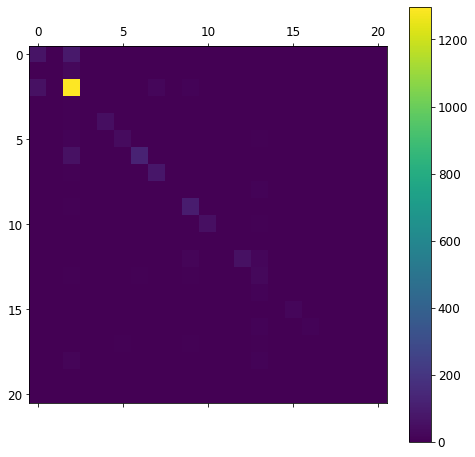

In [19]:
# since sklearn 0.22, you can use sklearn.metrics.plot_confusion_matrix()
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

#plt.matshow(conf_mx, cmap=plt.cm.gray) # greyscale version
plot_confusion_matrix(conf_mx)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

In [20]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Saving figure confusion_matrix_errors_plot


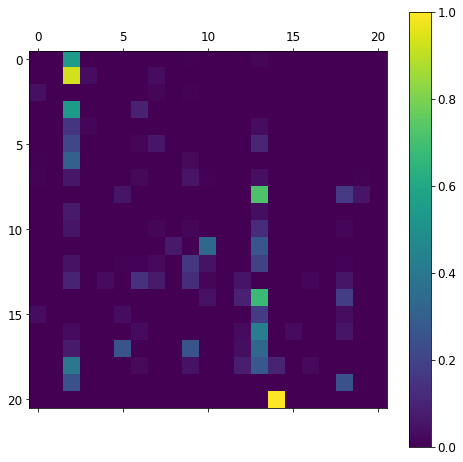

In [21]:
np.fill_diagonal(norm_conf_mx, 0)
# plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plot_confusion_matrix(norm_conf_mx)
save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

# Multi Classification for Random Forest
the book doesn't deal with this, but states that the Random Forest algorithm is "capable of handling multiple classes natively."

In [22]:
forest_clf=RandomForestClassifier(n_estimators=100)
y_train_pred_for1 = cross_val_predict(forest_clf, X_train_scaled, y_train_cat1, cv=3)
y_train_pred_for0 = cross_val_predict(forest_clf, X_train_scaled, y_train_cat0, cv=3)
y_train_pred_for2 = cross_val_predict(forest_clf, X_train_scaled, y_train_cat2, cv=3)

print(classification_report_imbalanced(y_train_cat1, y_train_pred_for1))
print(classification_report_imbalanced(y_train_cat0, y_train_pred_for0))

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


                   pre       rec       spe        f1       geo       iba       sup

          A       0.80      0.77      0.99      0.79      0.87      0.75       159
          B       0.53      0.34      1.00      0.42      0.59      0.32        29
          C       0.92      0.95      0.91      0.94      0.93      0.87      1410
          D       0.71      0.45      1.00      0.56      0.67      0.43        11
          E       0.89      0.83      1.00      0.86      0.91      0.81        59
          F       0.89      0.82      1.00      0.85      0.90      0.80        66
          G       0.88      0.90      0.99      0.89      0.95      0.89       186
          H       0.91      0.88      1.00      0.89      0.94      0.86        98
          I       0.83      0.83      1.00      0.83      0.91      0.82        18
          J       0.84      0.80      0.99      0.82      0.89      0.78       110
          K       0.82      0.82      0.99      0.82      0.90      0.80        71
   

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
print(classification_report_imbalanced(y_train_cat2, y_train_pred_for2))

                   pre       rec       spe        f1       geo       iba       sup

          1       0.75      0.77      0.99      0.76      0.87      0.75       132
          2       0.67      0.29      1.00      0.40      0.53      0.27         7
          3       0.75      0.75      1.00      0.75      0.87      0.73        20
          5       0.00      0.00      1.00      0.00      0.00      0.00         1
          6       0.00      0.00      1.00      0.00      0.00      0.00         3
          7       1.00      0.71      1.00      0.83      0.85      0.69         7
          8       0.63      0.80      1.00      0.71      0.89      0.78        15
          9       0.67      0.67      1.00      0.67      0.82      0.64         3
         10       0.77      0.73      0.99      0.75      0.85      0.70       156
         11       0.69      0.69      1.00      0.69      0.83      0.67        13
         12       1.00      0.75      1.00      0.86      0.87      0.73         4
   

# Multilabel classification
This is where there is more than one class. So in our case, we could check for Category_0 and Category_1. However, each category_1 class always belongs to the same Category_0 class, so this is a special case.

In [37]:

y_train_C = (y_train_cat1 == 'C')
y_train_2 = (y_train_cat0 == 2)

y_multilabel = np.c_[y_train_C, y_train_2]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [38]:
knn_clf.predict([test_item])

array([[ True,  True]])

In [39]:
## This code computes the average F1 score across all labels: it can take a long time but not here.
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.931940675708821

In [40]:
## This time it's a weighted average across all labels
f1_score(y_multilabel, y_train_knn_pred, average="weighted")

0.9321046659125645

#### I presume it's ok to use the imbalanced learn metrics here too..   
... acutally, no:   
ValueError: imblearn does not support multilabel

### How does it do on prediction?

In [43]:
y_knn_pred = knn_clf.predict(X_train)
y_knn_pred

array([[ True,  True],
       [False, False],
       [False, False],
       ...,
       [ True,  True],
       [ True,  True],
       [False, False]])

In [47]:
knn_result = y_multilabel.copy()
#knn_result['result'] = y_knn_pred
knn_result

array([[False, False],
       [False, False],
       [False, False],
       ...,
       [ True,  True],
       [ True,  True],
       [False, False]])

In [49]:
(y_knn_pred == y_multilabel)

array([[False, False],
       [ True,  True],
       [ True,  True],
       ...,
       [ True,  True],
       [ True,  True],
       [ True,  True]])

In [30]:
y_train_C = (y_train_cat1 == 'C')
y_train_2 = (y_train_cat0 == 2)
y_train_10 = (y_train_cat2 == 10)

y_multilabel = np.c_[y_train_C, y_train_2, y_train_10]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

In [31]:
f1_score(y_multilabel, y_train_knn_pred, average="weighted")

0.9211046676852388

In [33]:
knn_clf.predict([test_item])

array([[ True,  True,  True]])

In [36]:
X_train

array([[10.24176407,  1.495134  ,  6.934062  , ...,  7.17451763,
         6.48560524,  4.21679831],
       [ 6.43087292,  2.48803687,  1.78880703, ...,  3.84727097,
         6.04655981,  1.59090734],
       [10.60281658,  1.62183428,  7.01505661, ...,  8.39739513,
         6.74059629,  2.91967773],
       ...,
       [10.30541515,  1.78580189,  6.96380043, ...,  5.42338753,
         4.96495056,  7.99304438],
       [ 9.45425415,  2.33843803,  7.2139535 , ...,  7.08365107,
         6.09522724,  6.15777254],
       [ 6.34459972,  1.76774478,  1.20839155, ...,  3.46893382,
         6.57862043,  2.12571478]])